# Example Code for the 1x1 Optimum Filters
-----
Import `qetpy` and other necessary packages.

In [2]:
import numpy as np
import qetpy as qp
from pprint import pprint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Use `QETpy` to generate some simulated TES noise

We can use `qetpy.sim.TESnoise` to help create a simulated PSD with characteristic TES parameters.

In [3]:
fs = 1.25e6
f = np.fft.fftfreq(32768, d=1/fs)
noisesim = qp.sim.TESnoise(r0=0.03)
psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f)

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

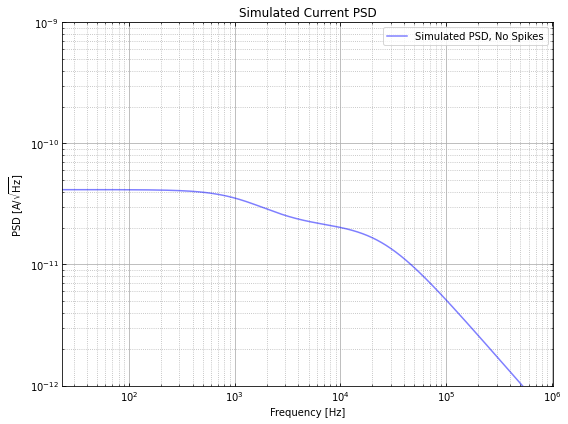

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(f_fold, psd_sim_fold**0.5, color="blue", alpha=0.5, label="Simulated PSD, No Spikes")
ax.set_ylim((1e-12,1e-9))
ax.grid()
ax.grid(which="minor", linestyle="dotted")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.legend(loc="best")
ax.set_title("Simulated Current PSD")
ax.set_ylabel("PSD [A/$\sqrt{\mathrm{Hz}}$]")
ax.set_xlabel("Frequency [Hz]")
fig.tight_layout()

With a PSD, we can use `qetpy.gen_noise` to generate random noise from the PSD (assuming the frequencies are uncorrelated). Then, we will create an example pulse.

In [5]:
# create a template
pulse_amp = 1.6e-6 # [A]
tau_f = 66e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(psd_sim))/fs
pretrigger_samples = len(t)//2
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template = pulse_shifted/pulse_shifted.max()

# use the PSD to create an example trace to fit
noise = qp.gen_noise(psd_sim, fs=fs, ntraces=1)[0]
signal = noise + np.roll(template, 200)*pulse_amp # note the shift we have added, 160 us

## Fit a single pulse with `OptimumFilter`

With a pulse created, let's use the `qetpy.OptimumFilter` class to run different Optimum Filters.

Below, we print the different methods available in `qetpy.OptimumFilter`. In this notebook, we will demo the `ofamp_nodelay`, `ofamp_withdelay`, `ofamp_pileup_iterative`, and `update_signal` methods. It is highly recommend to read the documentation for the other methods, as there are many useful ones!

In [6]:
method_list = sorted([func for func in dir(qp.OF1x1) if callable(getattr(qp.OF1x1, func)) and not func.startswith("__")])
pprint(method_list)

['calc',
 'calc_iterative',
 'calc_nodelay',
 'get_energy_resolution',
 'get_result_nodelay',
 'get_result_withdelay',
 'get_time_resolution',
 'plot']


Let's run the Optimum Filter without and with a time-shifting degree of freedom.

In [7]:
# instantiate OF1x1
OF = qp.OF1x1(template=template, psd=psd_sim, sample_rate=fs,
              pretrigger_samples=pretrigger_samples,
              channel_name='Sim') # initialize the OptimumFilter class

# calc
OF.calc(signal=signal, window_min_from_trig_usec=-500, window_max_from_trig_usec=500, 
        interpolate_t0=True, lgc_plot=False)

# get results
amp_nodelay, t0_nodelay, chi2_nodelay = OF.get_result_nodelay()
amp_withdelay, t0_withdelay, chi2_withdelay = OF.get_result_withdelay()

print(f"\nNo Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}")

INFO: Adding template with tag "default" to OF base object.
INFO: Adding noise PSD to OF base object

No Delay Fit: amp = -0.07 μA, χ^2 = 484694.26
With Delay Fit: amp = 1.60 μA, t_0 = 159.99492428546245 μs, χ^2 = 32913.72


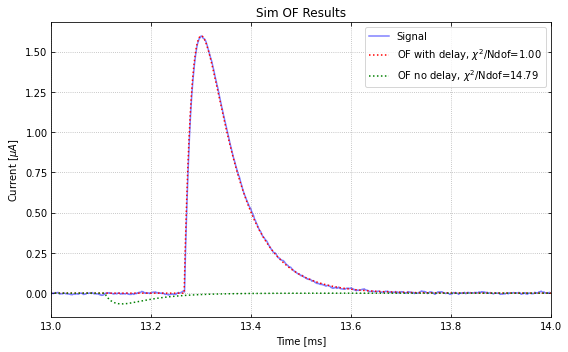

In [8]:
OF.plot(xlim_msec=(13,14))

Since we have added a 160 us shift, we see that the "with delay" optimum filter fit the time-shift perfectly, and the chi-squared is very close to the number of degrees of freedom (32768), as we would expect for a good fit.

### Same example but with OFBase object 

In [9]:
# instantiate OFBase
OFbase_obj = qp.OFBase(fs, pretrigger_samples=pretrigger_samples, channel_name='Sim')

# add template  (mutiple templates with different tag can be added)
# The function calculate template FFT
OFbase_obj.add_template(template)

# set PSD 
OFbase_obj.set_psd(psd_sim)

# update signal (update each event)
# By default, the function calculate FFT, optimal filter, filtered traces, and chi2/amp all times
# (calculation can be disabled)
OFbase_obj.update_signal(signal)

Let's instantiate OF1x1 and run the Optimum Filter without and with a time-shifting degree of freedom.


No Delay Fit: amp = -0.07 μA, χ^2 = 484694.26
With Delay Fit: amp = 1.60 μA, t_0 = 159.99492428546245 μs, χ^2 = 32913.72


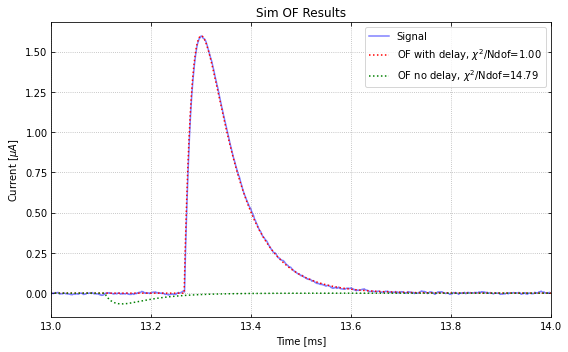

In [11]:
# instantiate
OF = qp.OF1x1(of_base=OFbase_obj)

# calc OF 
OF.calc(window_min_from_trig_usec=-500, window_max_from_trig_usec=500, 
        interpolate_t0=True, lgc_plot=False)

#get results
amp_nodelay, t0_nodelay, chi2_nodelay = OF.get_result_nodelay()
amp_withdelay, t0_withdelay, chi2_withdelay = OF.get_result_withdelay()

print(f"\nNo Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}")

#plot
OF.plot(xlim_msec=(13,14))